**Anomaly Detection with Autoencoders**<br>
link: https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770

In [39]:
# !pip install keras
# !pip install tensorflow==1.5
# !pip install hdbscan

    100% |████████████████████████████████| 4.0MB 2.4MB/s ta 0:00:011
  Installing build dependencies ... done
  Using cached https://files.pythonhosted.org/packages/0f/c9/3526a357b6c35e5529158fbcfac1bb3adc8827e8809a6d254019d326d1cc/numpy-1.16.4-cp36-cp36m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
    100% |████████████████████████████████| 286kB 3.3MB/s ta 0:00:01
  Running setup.py bdist_wheel for hdbscan ... done
  Stored in directory: /Users/sifatkhan/Library/Caches/pip/wheels/6d/f9/db/f2e5e704427932f5b05c91fc520effbb0bd10ba8d73fd3bfc7
Successfully built hdbscan
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4


In [9]:
# Common imports
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow import set_random_seed

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

Using TensorFlow backend.


In [10]:
df = pd.read_csv('loan_data_preprocessed.csv')

In [11]:
df.head()

,SEC.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,PRI.NO.OF.ACCTS,disbursed_amount,AVERAGE.ACCT.AGE,NO.OF_INQUIRIES,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,Aadhar_flag,VoterID_flag,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,Employment.Type_Self employed,PERFORM_CNS.SCORE.DESCRIPTION,loan_default
0,-0.039835,-0.091711,-0.467804,-0.291335,-0.590198,-0.292450,-0.086581,-0.020784,1,0,-0.012638,-0.004586,0.762134,-0.00326,-0.03102,-0.002388,0,-0.502999,0
1,-0.039835,-0.070599,-0.276131,-0.555997,0.932337,-0.292450,-0.073427,-0.020784,1,0,-0.012638,-0.004586,0.762134,-0.00326,-0.03102,-0.002388,1,0.536019,1
2,-0.039835,-0.091711,-0.467804,-0.083183,-0.590198,-0.292450,-0.086581,-0.020784,1,0,-0.012638,-0.004586,0.762134,-0.00326,-0.03102,-0.002388,1,-0.502999,0
3,-0.039835,-0.091711,0.107215,0.243307,-0.060621,1.122986,-0.086376,-0.020784,1,0,-0.012638,-0.004586,0.762134,-0.00326,-0.03102,-0.002388,1,0.495388,1
4,-0.039835,-0.091711,-0.467804,-0.152567,-0.590198,1.122986,-0.086581,-0.020784,1,0,-0.012638,-0.004586,0.762134,-0.00326,-0.03102,-0.002388,1,-0.502999,1


In [12]:
df.shape

(233154, 19)

In [13]:
df1 = df.drop(['loan_default'], axis = 1)

In [14]:
df1.shape

(233154, 18)

In [15]:
df1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SEC.SANCTIONED.AMOUNT,233154.0,-5.191946e-15,1.000002,-0.039835,-0.039835,-0.039835,-0.039835,163.755321
PRI.DISBURSED.AMOUNT,233154.0,8.396905e-16,1.000002,-0.091711,-0.091711,-0.091711,-0.066141,420.475940
PRI.NO.OF.ACCTS,233154.0,-1.097762e-16,1.000002,-0.467804,-0.467804,-0.467804,0.107215,86.360017
disbursed_amount,233154.0,1.711192e-15,1.000002,-3.163680,-0.555997,-0.042709,0.466878,72.175957
AVERAGE.ACCT.AGE,233154.0,-4.616265e-15,1.000002,-0.590198,-0.590198,-0.590198,0.270365,23.836562
NO.OF_INQUIRIES,233154.0,-1.354114e-14,1.000002,-0.292450,-0.292450,-0.292450,-0.292450,50.663239
PRIMARY.INSTAL.AMT,233154.0,1.656939e-14,1.000002,-0.086581,-0.086581,-0.086581,-0.073374,169.320937
SEC.INSTAL.AMT,233154.0,5.035490e-15,1.000002,-0.020784,-0.020784,-0.020784,-0.020784,268.141278
Aadhar_flag,233154.0,8.403201e-01,0.366310,0.000000,1.000000,1.000000,1.000000,1.000000
VoterID_flag,233154.0,1.449428e-01,0.352044,0.000000,0.000000,0.000000,0.000000,1.000000


In [71]:
# split the data for easier training (train using index that does not contain loan defaulters)
split_amount = 500
X_train = df1[:split_amount]
X_test = df1[split_amount:]
X_train.shape, X_test.shape

((500, 18), (232654, 18))

In [72]:
X_train.tail(1)

,SEC.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,PRI.NO.OF.ACCTS,disbursed_amount,AVERAGE.ACCT.AGE,NO.OF_INQUIRIES,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,Aadhar_flag,VoterID_flag,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,Employment.Type_Self employed,PERFORM_CNS.SCORE.DESCRIPTION
499,-0.039835,-0.043817,4.132346,-1.381358,-0.457804,-0.29245,-0.056316,-0.020784,1,0,-0.012638,-0.004586,-0.223803,-0.00326,-0.03102,-0.002388,1,0.485943


In [73]:
X_test.head(1)

,SEC.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,PRI.NO.OF.ACCTS,disbursed_amount,AVERAGE.ACCT.AGE,NO.OF_INQUIRIES,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,Aadhar_flag,VoterID_flag,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,Employment.Type_Self employed,PERFORM_CNS.SCORE.DESCRIPTION
500,-0.039835,-0.073206,-0.276131,1.674622,-0.524001,-0.29245,-0.086581,-0.020784,1,0,-0.012638,-0.004586,-0.223803,-0.00326,-0.03102,-0.002388,0,0.485943


**Defining the Autoencoder network:** <br>
We use a 3 layer neural network: First layer has 10 nodes, middle layer has 2 nodes, and third layer has 10 nodes. We use the mean square error as loss function, and train the model using the “Adam” optimizer.

In [74]:
seed(10)
set_random_seed(10)
act_func = 'elu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=100
BATCH_SIZE=10

**Fitting the model:**<br>
To keep track of the accuracy during training, we use 5% of the training data for validation after each epoch <br>(validation_split = 0.05)

In [75]:
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)

Train on 475 samples, validate on 25 samples
Epoch 1/100
475/475 [==============================] - 0s 539us/step - loss: 0.5812 - val_loss: 0.3043
Epoch 2/100
475/475 [==============================] - 0s 164us/step - loss: 0.5049 - val_loss: 0.2738
Epoch 3/100
475/475 [==============================] - 0s 173us/step - loss: 0.4599 - val_loss: 0.2511
Epoch 4/100
475/475 [==============================] - 0s 170us/step - loss: 0.4264 - val_loss: 0.2337
Epoch 5/100
475/475 [==============================] - 0s 161us/step - loss: 0.4015 - val_loss: 0.2200
Epoch 6/100
475/475 [==============================] - 0s 159us/step - loss: 0.3825 - val_loss: 0.2092
Epoch 7/100
475/475 [==============================] - 0s 171us/step - loss: 0.3681 - val_loss: 0.1997
Epoch 8/100
475/475 [==============================] - 0s 167us/step - loss: 0.3556 - val_loss: 0.1905
Epoch 9/100
475/475 [==============================] - 0s 158us/step - loss: 0.3439 - val_loss: 0.1799
Epoch 10/100
475/475 [======

**Visualize training/validation loss:**

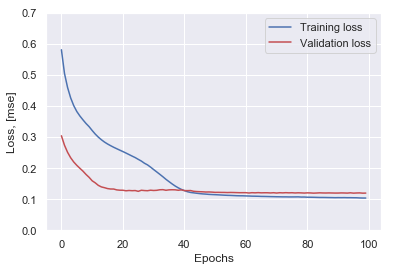

In [76]:
plt.plot(history.history['loss'],'b',label='Training loss')
plt.plot(history.history['val_loss'],'r',label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.7])
plt.show()

**Distribution of loss function in the training set:**<br>
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level”, and that any flagged anomalies should be statistically significant above the noise background.

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0.0, 0.9)

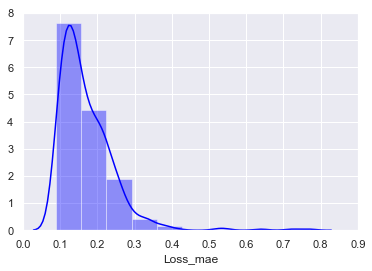

In [77]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.9])

In [78]:
threshold = 0.3

In [79]:
# on test data
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = threshold
scored['Anomaly'] = [1 if scored['Loss_mae'][row] > scored['Threshold'][row] else 0 for row in scored.index]
scored.head()

,Loss_mae,Threshold,Anomaly
500,0.259369,0.3,0
501,0.153464,0.3,0
502,0.130783,0.3,0
503,0.098384,0.3,0
504,0.118388,0.3,0


In [80]:
scored.shape[0], scored[scored.Anomaly == True].shape[0], scored[scored.Anomaly == True].shape[0]/scored.shape[0]

(232654, 43410, 0.18658608921402597)

In [81]:
scored.shape[0], scored[scored.Anomaly == 1].shape[0], scored[scored.Anomaly == 1].shape[0]/scored.shape[0]

(232654, 43410, 0.18658608921402597)

In [82]:
# on train data
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = threshold
scored_train['Anomaly'] = [1 if scored_train['Loss_mae'][row] > scored_train['Threshold'][row] else 0 for row in scored_train.index]
scored = pd.concat([scored_train, scored])

In [83]:
scored.shape[0], scored[scored.Anomaly == 1].shape[0], scored[scored.Anomaly == 1].shape[0]/scored.shape[0]

(233154, 43432, 0.18628031258309957)

In [84]:
scored['loan_default'] = df['loan_default']

In [85]:
scored.shape[0], scored[scored.loan_default == 1].shape[0], scored[scored.loan_default == 1].shape[0]/scored.shape[0]

(233154, 50611, 0.2170711203753742)

In [86]:
# confusion matrix to evaluate anomaly and defaulter overlap
confusion_matrix(scored['loan_default'], scored['Anomaly'],[0,1])

array([[149767,  32776],
       [ 39955,  10656]])

In [87]:
print(classification_report(scored['loan_default'], scored['Anomaly']))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80    182543
           1       0.25      0.21      0.23     50611

   micro avg       0.69      0.69      0.69    233154
   macro avg       0.52      0.52      0.52    233154
weighted avg       0.67      0.69      0.68    233154



In [88]:
10657/(39954+10657)

0.21056687281421035

In [89]:
scored.shape

(233154, 4)

**DBSCAN clustering:** <br>
link: https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html<br>
viz:  https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/<br>
**HDBSCAN clustering:**<br>
Link: https://towardsdatascience.com/lightning-talk-clustering-with-hdbscan-d47b83d1b03a

**eval diff clusters** <br>
Link: https://nbviewer.jupyter.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb

In [3]:
%matplotlib inline
from collections import Counter
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import hdbscan

In [13]:
X_train.columns, X_train.shape

(Index(['SEC.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'PRI.NO.OF.ACCTS',
        'disbursed_amount', 'AVERAGE.ACCT.AGE', 'NO.OF_INQUIRIES',
        'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'Aadhar_flag', 'VoterID_flag',
        'branch_id', 'supplier_id', 'manufacturer_id', 'Current_pincode_ID',
        'State_ID', 'Employee_code_ID', 'Employment.Type_Self employed',
        'PERFORM_CNS.SCORE.DESCRIPTION'],
       dtype='object'), (500, 18))

In [15]:
X_train['SEC.SANCTIONED.AMOUNT'].value_counts()

-0.039835     495
 0.019869       1
 35.039628      1
 9.187293       1
 0.148301       1
 0.178559       1
Name: SEC.SANCTIONED.AMOUNT, dtype: int64

**Fit a DBSCAN estimator**

In [34]:
# Fit a DBSCAN estimator
estimator = DBSCAN(eps=0.80, min_samples=10)
X = df1.iloc[:,:]
print(X.shape)
estimator.fit(X)

# Clusters are given in the labels_ attribute
labels = estimator.labels_
print(Counter(labels)), len(labels.tolist())

(233154, 18)
Counter({10: 32226, 19: 29263, 11: 27655, 16: 25882, 2: 11962, 0: 10882, -1: 10877, 1: 7843, 5: 7772, 77: 5213, 22: 5057, 20: 4341, 23: 3951, 17: 2363, 75: 2005, 7: 1957, 14: 1924, 3: 1731, 72: 1716, 18: 1701, 24: 1679, 78: 1657, 29: 1425, 21: 1392, 53: 1389, 26: 1345, 50: 1237, 48: 1192, 86: 1142, 41: 1075, 132: 1051, 32: 876, 9: 767, 38: 706, 73: 662, 40: 631, 6: 589, 103: 586, 27: 584, 4: 561, 42: 474, 13: 454, 59: 437, 84: 437, 28: 419, 39: 417, 80: 416, 182: 400, 81: 388, 15: 351, 85: 341, 147: 306, 45: 292, 107: 291, 65: 281, 133: 268, 30: 266, 37: 264, 99: 261, 145: 253, 93: 252, 49: 248, 60: 248, 58: 238, 63: 219, 89: 219, 91: 212, 149: 207, 44: 205, 135: 203, 56: 194, 102: 188, 83: 181, 101: 171, 87: 166, 34: 164, 47: 164, 109: 147, 70: 144, 134: 143, 76: 134, 88: 132, 116: 130, 98: 127, 31: 126, 25: 125, 136: 124, 74: 123, 146: 123, 61: 121, 52: 120, 66: 120, 120: 120, 131: 110, 35: 107, 92: 106, 155: 100, 67: 99, 46: 97, 108: 97, 97: 90, 57: 87, 106: 87, 68: 85,

(None, 233154)

In [35]:
labels.shape

(233154,)

In [36]:
X['db_clusters'] = labels

In [38]:
X.db_clusters.value_counts()

 10     32226
 19     29263
 11     27655
 16     25882
 2      11962
 0      10882
-1      10877
 1       7843
 5       7772
 77      5213
 22      5057
 20      4341
 23      3951
 17      2363
 75      2005
 7       1957
 14      1924
 3       1731
 72      1716
 18      1701
 24      1679
 78      1657
 29      1425
 21      1392
 53      1389
 26      1345
 50      1237
 48      1192
 86      1142
 41      1075
        ...  
 69        16
 43        15
 170       15
 165       15
 123       14
 140       14
 125       14
 159       14
 55        14
 181       13
 186       13
 151       13
 180       13
 162       13
 172       13
 184       12
 164       12
 160       11
 163       11
 105       11
 100       11
 178       11
 138       11
 173       10
 189       10
 188       10
 187       10
 179       10
 177       10
 176        9
Name: db_clusters, Length: 191, dtype: int64

In [90]:
X['anomaly'] = scored['Anomaly']
X['loan_default'] = df['loan_default']

In [91]:
X.head()

,SEC.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,PRI.NO.OF.ACCTS,disbursed_amount,AVERAGE.ACCT.AGE,NO.OF_INQUIRIES,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,Aadhar_flag,VoterID_flag,...,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,Employment.Type_Self employed,PERFORM_CNS.SCORE.DESCRIPTION,db_clusters,loan_default,anomaly
0,-0.039835,-0.091711,-0.467804,-0.291335,-0.590198,-0.292450,-0.086581,-0.020784,1,0,...,-0.004586,0.762134,-0.00326,-0.03102,-0.002388,0,-0.502999,0,0,0
1,-0.039835,-0.070599,-0.276131,-0.555997,0.932337,-0.292450,-0.073427,-0.020784,1,0,...,-0.004586,0.762134,-0.00326,-0.03102,-0.002388,1,0.536019,1,1,0
2,-0.039835,-0.091711,-0.467804,-0.083183,-0.590198,-0.292450,-0.086581,-0.020784,1,0,...,-0.004586,0.762134,-0.00326,-0.03102,-0.002388,1,-0.502999,2,0,0
3,-0.039835,-0.091711,0.107215,0.243307,-0.060621,1.122986,-0.086376,-0.020784,1,0,...,-0.004586,0.762134,-0.00326,-0.03102,-0.002388,1,0.495388,3,1,0
4,-0.039835,-0.091711,-0.467804,-0.152567,-0.590198,1.122986,-0.086581,-0.020784,1,0,...,-0.004586,0.762134,-0.00326,-0.03102,-0.002388,1,-0.502999,4,1,0


In [93]:
print(X.loan_default.value_counts(),'\n', X.anomaly.value_counts())

0    182543
1     50611
Name: loan_default, dtype: int64 
 0    189722
1     43432
Name: anomaly, dtype: int64


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



*** db_clusters ***

 # levels: 64 
head:
              sum  count      mean
db_clusters                      
182          238    400  0.595000
92            43    106  0.405660
103          237    586  0.404437
98            47    127  0.370079
93            92    252  0.365079 

tail:
               sum  count      mean
db_clusters                       
2            2662  11962  0.222538
85             75    341  0.219941
37             58    264  0.219697
32            191    876  0.218037
10           7004  32226  0.217340


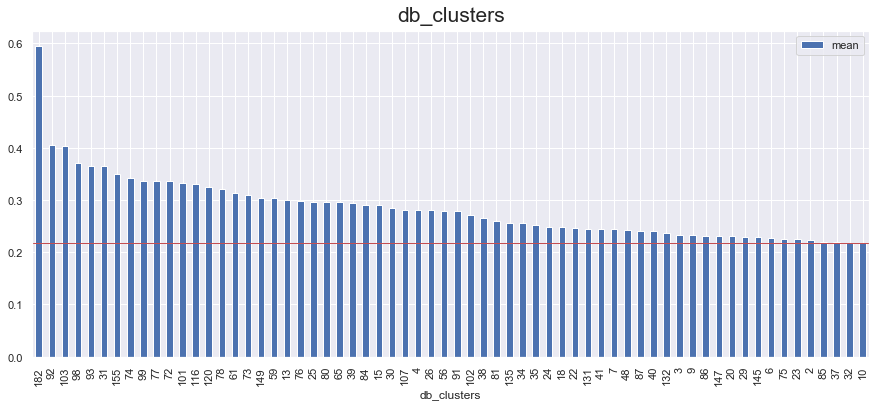

In [45]:
threshold = 0.217071
col = 'db_clusters'
# for col in cat_cols2:
try:
    grouped=X.groupby(col)['loan_default'].agg(['sum','count','mean'])
    grouped1=grouped.sort_values(ascending=False, by= 'count')
    grouped2=grouped1[grouped1['count']>99].sort_values(ascending=False, by= 'mean')
    grouped3=grouped2[grouped1['mean']>threshold].sort_values(ascending=False, by= 'mean')
    print('\n***',col,'***\n\n','# levels:',grouped3.shape[0], '\nhead:\n',grouped3.head(),'\n\ntail:\n',grouped3.tail())


    ax = grouped3[['mean']].plot(kind='bar', figsize=(15,6));
    ax.set_title(col, fontsize=21, y=1.01);
    # horizontal line indicating the threshold
    plt.axhline(y=threshold,linewidth=1, color='r')
    plt.show();

except:
    print('\n***',col,'***\n\n')

In [94]:
X[X.db_clusters==182].loan_default.value_counts()

1    238
0    162
Name: loan_default, dtype: int64

In [95]:
X.columns

Index(['SEC.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'PRI.NO.OF.ACCTS',
       'disbursed_amount', 'AVERAGE.ACCT.AGE', 'NO.OF_INQUIRIES',
       'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'Aadhar_flag', 'VoterID_flag',
       'branch_id', 'supplier_id', 'manufacturer_id', 'Current_pincode_ID',
       'State_ID', 'Employee_code_ID', 'Employment.Type_Self employed',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'db_clusters', 'loan_default',
       'anomaly'],
      dtype='object')

In [105]:
col = 'db_clusters'
grouped=X.groupby(col)['loan_default'].agg(['sum','count','mean'])
grouped_filtered = grouped[(grouped['count']>99)&(grouped['mean']>0.217071)]
selected_level = grouped_filtered.index.tolist()

new_col = []
for level in X[col]:
    if level in selected_level:
        new_col.append(level)
    else:
        new_col.append('NA')

In [106]:
len(new_col)

233154

In [109]:
len(Counter(new_col))

65

In [ ]:
# X['db_clusters'] = new_col

In [115]:
df_temp = pd.get_dummies(new_col)
df_temp = df_temp.drop(['NA'], axis=1)
print(df_temp.shape, '\n', df_temp.columns)

(233154, 64) 
 Index([  2,   3,   4,   6,   7,   9,  10,  13,  15,  18,  20,  22,  23,  24,
        25,  26,  29,  30,  31,  32,  34,  35,  37,  38,  39,  40,  41,  48,
        56,  59,  61,  65,  72,  73,  74,  75,  76,  77,  78,  80,  81,  84,
        85,  86,  87,  91,  92,  93,  98,  99, 101, 102, 103, 107, 116, 120,
       131, 132, 135, 145, 147, 149, 155, 182],
      dtype='object')


In [120]:
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(df_temp).reshape(df_temp.shape[0],).tolist()
len(principalComponents), Counter(principalComponents)

(233154,
 Counter({-0.12951289873513083: 1,
          -0.1295128987351526: 136598,
          -0.22595933381072286: 11962,
          -0.13803901141260258: 1731,
          -0.13215841090764108: 561,
          -0.13229328536652674: 589,
          -0.13923574959918042: 1957,
          -0.1331571813628646: 767,
          0.8640193650430948: 32226,
          -0.13164552148154532: 454,
          -0.13115555196133663: 351,
          -0.13788169428831165: 1701,
          -0.15325094960248717: 4341,
          -0.1580283344880172: 5057,
          -0.15076829177283219: 3951,
          -0.1377665625741566: 1679,
          -0.1300931505930676: 125,
          -0.1360419061460795: 1345,
          -0.13645105124923768: 1425,
          -0.13075394661784184: 266,
          -0.13009781357250896: 126,
          -0.1336917885995435: 876,
          -0.13027525482612595: 164,
          -0.13000927408506802: 107,
          -0.1307445266940597: 264,
          -0.13285985920810503: 706,
          -0.131469092247

In [121]:
X['db_clusters_PCA'] = principalComponents

In [124]:
X.columns, X.shape

(Index(['SEC.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'PRI.NO.OF.ACCTS',
        'disbursed_amount', 'AVERAGE.ACCT.AGE', 'NO.OF_INQUIRIES',
        'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'Aadhar_flag', 'VoterID_flag',
        'branch_id', 'supplier_id', 'manufacturer_id', 'Current_pincode_ID',
        'State_ID', 'Employee_code_ID', 'Employment.Type_Self employed',
        'PERFORM_CNS.SCORE.DESCRIPTION', 'db_clusters', 'loan_default',
        'anomaly', 'db_clusters_PCA'],
       dtype='object'), (233154, 22))

In [133]:
X[X.db_clusters==92].db_clusters_PCA.value_counts()

-0.130005    106
Name: db_clusters_PCA, dtype: int64

**Fit a HDBSCAN estimator**

In [18]:
# Fit a HDBSCAN estimator
estimator = hdbscan.HDBSCAN(min_cluster_size=15, allow_single_cluster=True)
estimator.fit(df1)

# Clusters are given in the labels_ attribute
labels = estimator.labels_
print(Counter(labels)), len(labels.tolist())

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


Counter({-1: 57410, 1107: 26197, 304: 25433, 196: 7708, 235: 7635, 61: 4196, 92: 3529, 221: 2258, 44: 1916, 40: 1707, 217: 1632, 207: 1311, 339: 1311, 30: 1261, 71: 1222, 126: 1186, 303: 1152, 165: 1088, 203: 1060, 118: 1051, 28: 982, 111: 874, 125: 818, 120: 775, 195: 718, 47: 713, 247: 618, 135: 552, 187: 545, 596: 502, 57: 499, 191: 499, 24: 432, 16: 415, 194: 398, 20: 394, 192: 374, 167: 343, 157: 342, 12: 322, 480: 318, 23: 293, 103: 286, 26: 282, 156: 268, 220: 267, 109: 266, 161: 259, 210: 255, 106: 255, 110: 252, 124: 251, 108: 243, 100: 236, 3: 234, 54: 223, 55: 212, 206: 211, 163: 204, 1655: 202, 115: 196, 1517: 193, 151: 189, 1344: 186, 1151: 185, 1602: 184, 175: 178, 359: 174, 188: 171, 97: 170, 60: 167, 8: 166, 1339: 164, 148: 164, 1685: 163, 64: 162, 1650: 159, 1370: 158, 237: 158, 168: 153, 999: 151, 1323: 149, 966: 148, 43: 147, 129: 144, 1013: 142, 95: 141, 2: 140, 281: 140, 439: 139, 1736: 136, 1485: 135, 1598: 133, 149: 133, 218: 133, 345: 131, 104: 131, 1697: 130, 1

(None, 233154)

In [22]:
X1 = pd.read_csv('loan_data_preprocessed2.csv')
X1.shape, X1.columns

((233154, 22),
 Index(['SEC.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'PRI.NO.OF.ACCTS',
        'disbursed_amount', 'AVERAGE.ACCT.AGE', 'NO.OF_INQUIRIES',
        'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'Aadhar_flag', 'VoterID_flag',
        'branch_id', 'supplier_id', 'manufacturer_id', 'Current_pincode_ID',
        'State_ID', 'Employee_code_ID', 'Employment.Type_Self employed',
        'PERFORM_CNS.SCORE.DESCRIPTION', 'db_clusters', 'loan_default',
        'anomaly', 'db_clusters_PCA'],
       dtype='object'))

In [23]:
X1['hdb_clusters'] = labels

In [24]:
X1.shape, X1.columns

((233154, 23),
 Index(['SEC.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'PRI.NO.OF.ACCTS',
        'disbursed_amount', 'AVERAGE.ACCT.AGE', 'NO.OF_INQUIRIES',
        'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'Aadhar_flag', 'VoterID_flag',
        'branch_id', 'supplier_id', 'manufacturer_id', 'Current_pincode_ID',
        'State_ID', 'Employee_code_ID', 'Employment.Type_Self employed',
        'PERFORM_CNS.SCORE.DESCRIPTION', 'db_clusters', 'loan_default',
        'anomaly', 'db_clusters_PCA', 'hdb_clusters'],
       dtype='object'))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



*** hdb_clusters ***

 # levels: 79 
head:
               sum  count      mean
hdb_clusters                      
277            43    100  0.430000
218            56    133  0.421053
167           140    343  0.408163
2              52    140  0.371429
3              86    234  0.367521 

tail:
               sum  count      mean
hdb_clusters                      
161            57    259  0.220077
121            26    119  0.218487
1163           24    110  0.218182
1011           27    124  0.217742
111           190    874  0.217391


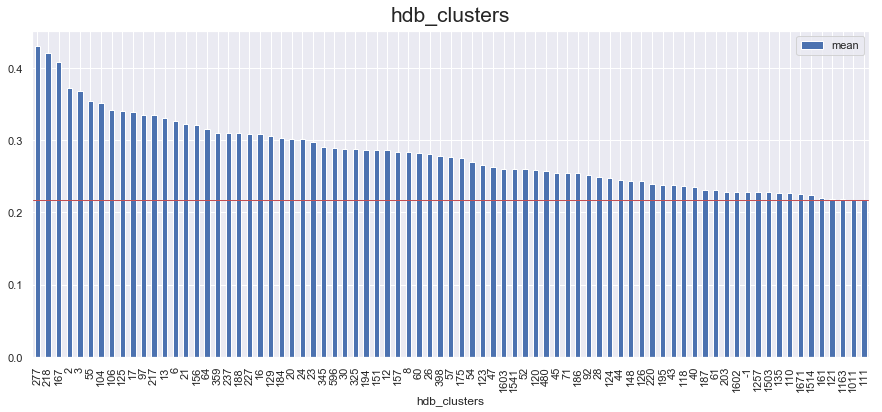

In [25]:
threshold = 0.217071
col = 'hdb_clusters'
# for col in cat_cols2:
try:
    grouped=X1.groupby(col)['loan_default'].agg(['sum','count','mean'])
    grouped1=grouped.sort_values(ascending=False, by= 'count')
    grouped2=grouped1[grouped1['count']>99].sort_values(ascending=False, by= 'mean')
    grouped3=grouped2[grouped1['mean']>threshold].sort_values(ascending=False, by= 'mean')
    print('\n***',col,'***\n\n','# levels:',grouped3.shape[0], '\nhead:\n',grouped3.head(),'\n\ntail:\n',grouped3.tail())


    ax = grouped3[['mean']].plot(kind='bar', figsize=(15,6));
    ax.set_title(col, fontsize=21, y=1.01);
    # horizontal line indicating the threshold
    plt.axhline(y=threshold,linewidth=1, color='r')
    plt.show();

except:
    print('\n***',col,'***\n\n')

In [29]:
col = 'hdb_clusters'
grouped=X1.groupby(col)['loan_default'].agg(['sum','count','mean'])
grouped_filtered = grouped[(grouped['count']>99)&(grouped['mean']>0.217071)]
selected_level = grouped_filtered.index.tolist()

new_col = []
for level in X1[col]:
    if level in selected_level:
        new_col.append(level)
    else:
        new_col.append('NA')

In [30]:
df_temp = pd.get_dummies(new_col)
df_temp = df_temp.drop(['NA'], axis=1)
print(df_temp.shape, '\n', df_temp.columns)

(233154, 79) 
 Index([  -1,    2,    3,    6,    8,   12,   13,   16,   17,   20,   21,   23,
         24,   26,   28,   30,   40,   43,   44,   45,   47,   52,   54,   55,
         57,   60,   61,   64,   71,   92,   97,  104,  106,  110,  111,  118,
        120,  121,  123,  124,  125,  126,  129,  135,  148,  151,  156,  157,
        161,  167,  175,  184,  186,  187,  188,  194,  195,  203,  217,  218,
        220,  227,  237,  277,  325,  345,  359,  398,  480,  596, 1011, 1163,
       1257, 1503, 1514, 1541, 1602, 1603, 1671],
      dtype='object')


In [31]:
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(df_temp).reshape(df_temp.shape[0],).tolist()
len(principalComponents), Counter(principalComponents)

(233154,
 Counter({-0.24460305410273733: 1,
          -0.24460305410272443: 139068,
          -0.25462878034060155: 1707,
          -0.24745121796710132: 499,
          -0.24771711678053474: 545,
          -0.2559130587424159: 1916,
          -0.248722264143594: 718,
          0.7544195716363946: 57410,
          -0.24706495017912258: 432,
          -0.24593045774889188: 234,
          -0.2464333876917907: 322,
          -0.2708139150117634: 4196,
          -0.2662782039199009: 3529,
          -0.2516976085462301: 1222,
          -0.24519123798072484: 208,
          -0.2519308135902365: 1261,
          -0.24586773580631738: 223,
          -0.24963565958311787: 874,
          -0.24543525679173672: 147,
          -0.2452252579840933: 330,
          -0.24607312670047463: 259,
          -0.24530467471679313: 124,
          -0.24869309918516375: 713,
          -0.24684640838541583: 394,
          -0.24775762974751242: 552,
          -0.25027195018852644: 982,
          -0.24539549970633767:

In [33]:
X1['hdb_clusters_PCA'] = principalComponents

In [34]:
# save data for supervised learning models
X1.to_csv('loan_data_preprocessed2.csv', index=False)